In [231]:
import numpy as np

from astropy import units as u
from astropy import constants as c
from astropy.table import Table
from astropy.modeling import models, fitting
import galarp as grp

grp.pyplot_style()

from matplotlib import pyplot as plt

from gala.units import UnitSystem   

from gala import integrate as gi
from gala import dynamics as gd
from gala import potential as gp
from gala.units import galactic

In [3]:
test_host_potential = grp.builtins.JZ2023_1e14()

host_1e12 = grp.HostOrbit(potential=grp.builtins.JZ2023_1e12(), init_conditions=grp.builtins.JZ2023_1e12_IC())
host_1e13 = grp.HostOrbit(potential=grp.builtins.JZ2023_1e13(), init_conditions=grp.builtins.JZ2023_1e13_IC())


host_1e14 = grp.HostOrbit(potential=grp.builtins.JZ2023_1e14(), 
                          init_conditions=grp.builtins.JZ2023_1e14_IC(),
                          density=grp.SphericalBetaModel())


host_1e12.integrate(n_steps=100000)
host_1e13.integrate(n_steps=100000)
host_1e14.integrate(n_steps=10000)

test_satellite = grp.builtins.JZ2023_Satellite()

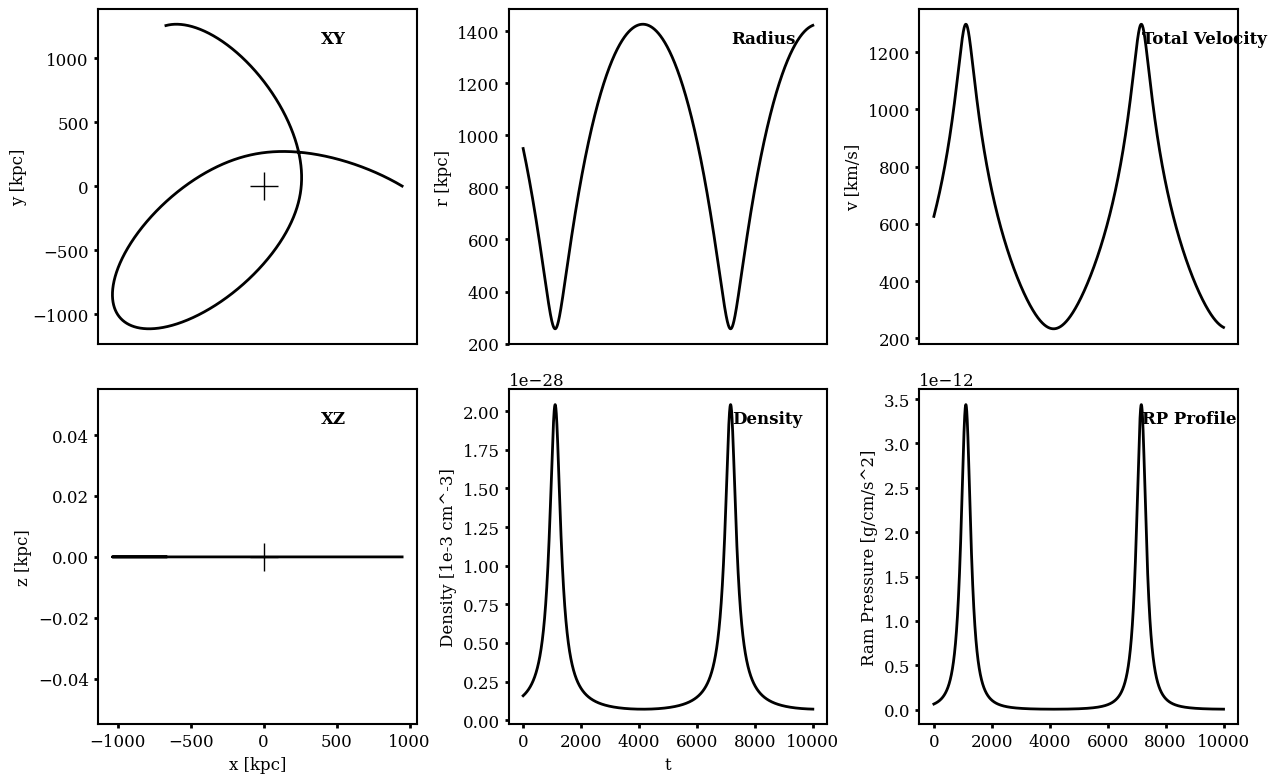

In [6]:

    
host_1e14.plot_infall_orbit(outname='infall_orbit.png')



In [7]:
def gen_ENZO_filename(host, units = UnitSystem(u.cm, u.s, u.radian, u.g)):
    
    t = host.orbit.t.to(units['time'])

    x, y, z = host.orbit.pos.xyz
    r = np.sqrt(x**2 + y**2 + z**2)

    # Get density
    dens = host.density.evaluate(r)

    dx, dy, dz = host.orbit.vel.d_xyz
    
    temps = [host.temp.value for i in range(len(t))]

gen_ENZO_filename(host_1e14)

In [8]:
from astropy import units as u

def test_rho(r0 = 11.87 * u.kpc):
    return 1.46e-24 * (r0 / (3.07 * u.kpc))**(-2/3) * (u.g / u.cm**3)


In [138]:
coma_mass = 1.4e15 * u.Msun

coma_pot = gp.NFWPotential.from_M200_c(M200=coma_mass, 
                                        c=9, 
                                        units=galactic)

vx = -1500
vy =  400
vz = -2420

vel = [vx, vy, vz] * u.km / u.s

pos = [355, 0, 0] * u.kpc


print(pos)
print(vel)

[355.   0.   0.] kpc
[-1500.   400. -2420.] km / s


In [293]:
def gen_coma_orbit(dw_angle=25):

    coma_mass = 1.4e15 * u.Msun
    concentration = 9

    coma_pot = gp.NFWPotential.from_M200_c(M200=coma_mass, 
                                            c=concentration, 
                                            units=galactic)

    pos = [355, 0, 0] * u.kpc

    vrad = -2420
    vtot = vrad / np.cos(np.deg2rad(dw_angle))
    v_pos = np.sqrt(vtot**2 - vrad**2)

    vel = [v_pos, 0, vrad] * u.km / u.s

    w0 = gd.PhaseSpacePosition(pos=pos, vel=vel)

    n_steps = 1000
    dt = 5 * u.Myr

    orbits_forward = gp.Hamiltonian(coma_pot).integrate_orbit(w0, dt=dt, n_steps=n_steps)
    orbits_backward = gp.Hamiltonian(coma_pot).integrate_orbit(w0, dt=-dt, n_steps=n_steps)

    q_forward = orbits_forward.pos.xyz
    q_backward = orbits_backward.pos.xyz
    p_forward = orbits_forward.vel.d_xyz
    p_backward = orbits_backward.vel.d_xyz

    ts_forward = orbits_forward.t
    ts_backward = orbits_backward.t

    q_backward = np.flip(q_backward, axis=1)
    p_backward = np.flip(p_backward, axis=1)
    ts_backward = np.flip(ts_backward)

    q_tot = np.concatenate((q_backward, q_forward), axis=1)
    p_tot = np.concatenate((p_backward, p_forward), axis=1)
    ts_tot = np.concatenate((ts_backward, ts_forward))

    ts_tot -= np.min(ts_tot)

    return ts_tot, q_tot, p_tot

ts, qs, ps = gen_coma_orbit()


In [294]:
@models.custom_model()
def Beta_Model(x, n_0=1., r_c=1., beta=1.):
    return (n_0 * (1. + (x/r_c)**2) ** (-3.*beta/2.))



Model: Beta_Model
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
             n_0                  r_c               beta       
    ---------------------- ----------------- ------------------
    2.2693100137522132e-26 83.44855044763145 0.5415934212068201


/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/astropy/modeling/fitting.py:1448: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn(


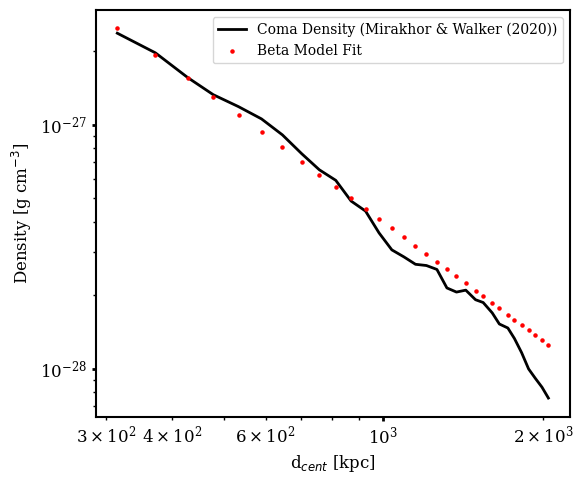

In [295]:
t_coma_density = Table.read("Coma-Density.csv", format="csv")

radii, density = t_coma_density['Radius'], t_coma_density['Density']

radii *= 60 * 0.468

density *= u.cm ** -3
density *= c.m_p

density = density.to(u.g / u.cm**3)

fitter = fitting.LevMarLSQFitter()

fit = fitter(Beta_Model(n_0=1e-27, beta=0.5), radii.value, density.value)
print(fit)
plt.figure(figsize=(6,5))

plt.plot(radii, density, color="black", lw=2, label="Coma Density (Mirakhor & Walker (2020))")
plt.scatter(radii, fit(radii), color="Red", s=5, zorder=3, label="Beta Model Fit")

xlims, ylims = plt.xlim(), plt.ylim()


plt.legend(loc="upper right", fontsize=10)
plt.xlabel("d$_{cent}$ [kpc]")
plt.ylabel('Density [g cm$^{-3}$]')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.show()

In [321]:
def gen_coma_orbit(dw_angle=25):

    coma_mass = 1.4e15 * u.Msun
    concentration = 9

    coma_pot = gp.NFWPotential.from_M200_c(M200=coma_mass, 
                                            c=concentration, 
                                            units=galactic)

    pos = [355, 0, 0] * u.kpc

    vrad = -2420
    vtot = vrad / np.cos(np.deg2rad(dw_angle))
    v_pos = np.sqrt(vtot**2 - vrad**2)

    vel = [v_pos, 0, vrad] * u.km / u.s

    w0 = gd.PhaseSpacePosition(pos=pos, vel=vel)

    n_steps = 1000
    dt = 5 * u.Myr

    orbits_forward = gp.Hamiltonian(coma_pot).integrate_orbit(w0, dt=dt, n_steps=n_steps)
    orbits_backward = gp.Hamiltonian(coma_pot).integrate_orbit(w0, dt=-dt, n_steps=n_steps)

    q_forward = orbits_forward.pos.xyz
    q_backward = orbits_backward.pos.xyz
    p_forward = orbits_forward.vel.d_xyz
    p_backward = orbits_backward.vel.d_xyz

    ts_forward = orbits_forward.t
    ts_backward = orbits_backward.t

    q_backward = np.flip(q_backward, axis=1)
    p_backward = np.flip(p_backward, axis=1)
    ts_backward = np.flip(ts_backward)

    q_tot = np.concatenate((q_backward, q_forward), axis=1)
    p_tot = np.concatenate((p_backward, p_forward), axis=1)
    ts_tot = np.concatenate((ts_backward, ts_forward))

    ts_tot -= np.min(ts_tot)

    return ts_tot, q_tot, p_tot

angles = [15, 17, 20, 25]
sets = []

for angle in angles:
    sets.append(gen_coma_orbit(angle))




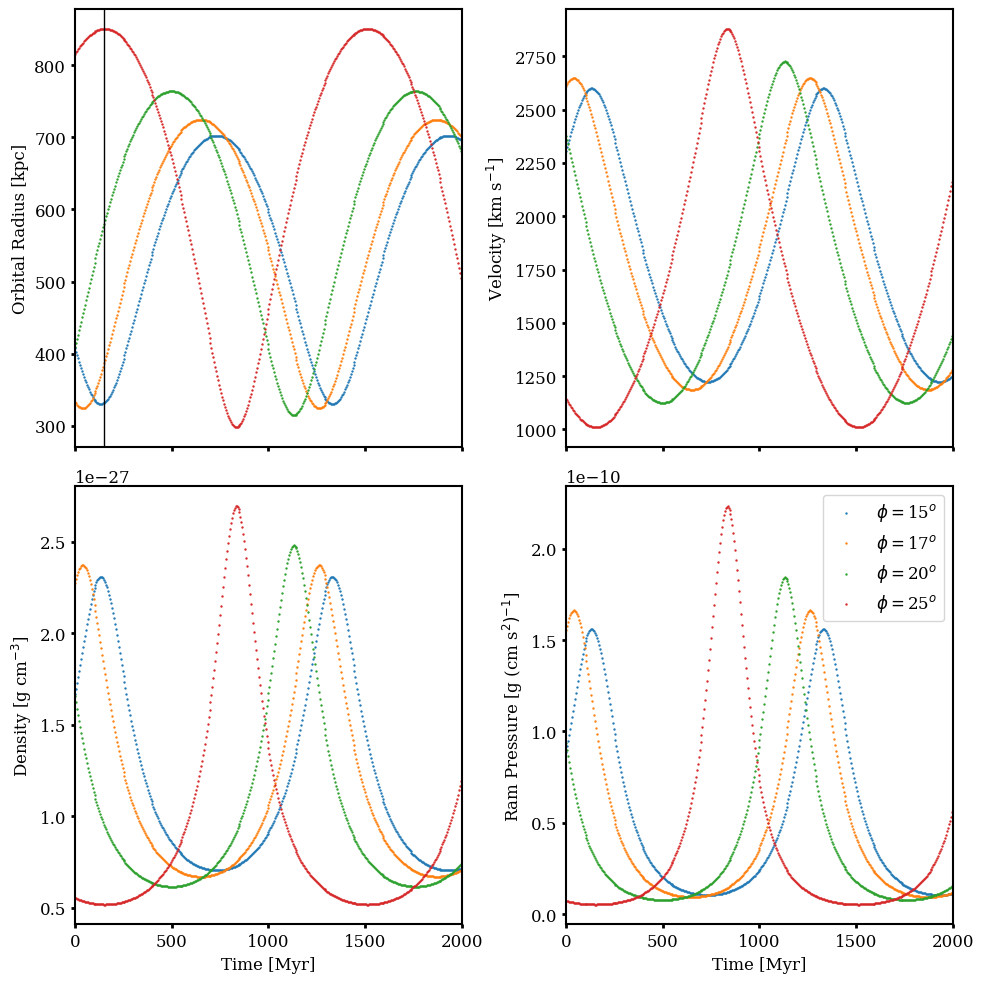

In [331]:
r = np.sqrt(np.sum(qs**2, axis=0))
v_tot = np.sqrt(np.sum(ps**2, axis=0)).to(u.km / u.s)

density = fit(r.value) * (u.g / u.cm**3)

rpp = (density * v_tot ** 2).to(u.g / u.cm / u.s**2)

i0 = 30

t0 = 0
period = 2000

folded_time = (ts.value + t0) #% period


fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True)

for i, set in enumerate(sets):
    time, q, p = set
    r = np.sqrt(np.sum(q**2, axis=0))
    v_tot = np.sqrt(np.sum(p**2, axis=0)).to(u.km / u.s)

    density = fit(r.value) * (u.g / u.cm**3)

    rpp = (density * v_tot ** 2).to(u.g / u.cm / u.s**2)

    folded_time = (time + t0) #% period

    ax[0][0].scatter(folded_time, r, s=0.5)
    ax[0][1].scatter(folded_time, v_tot, s=0.5)

    ax[1][0].scatter(folded_time, density, s=0.5)
    ax[1][1].scatter(folded_time, rpp, s=0.5, label=f'$\phi = ${angles[i]}$^o$')


ax[0][0].set_ylabel("Orbital Radius [kpc]")
ax[0][1].set_ylabel("Velocity [km s$^{-1}$]")

ax[1][0].set_ylabel("Density [g cm$^{-3}$]")

ax[1][1].set_ylabel("Ram Pressure [g (cm s$^{2})^{-1}$]")

ax[0][0].axvline(ts[i0].value)

for axis in ax[1]:
    axis.set_xlabel("Time [Myr]")

for axis in ax.flatten():
    axis.set_xlim(0, period)

plt.legend()
plt.tight_layout()
plt.savefig("Coma Cluster Orbits")

In [396]:
dw_angle = 17

time, q, p = gen_coma_orbit(dw_angle)
r = np.sqrt(np.sum(q**2, axis=0))
v_tot = np.sqrt(np.sum(p**2, axis=0)).to(u.km / u.s)

density = fit(r.value) * (u.g / u.cm**3)



time_ts = time[i0:].cgs.value
rho_ts = density[i0:].cgs.value

temp_ts = np.array([1e7 for i in range(len(time_ts))])


vx_ts = np.zeros(len(time_ts))
vy_ts  = (v_tot[i0:] * np.cos(np.deg2rad(dw_angle))).cgs.value
vz_ts = (v_tot[i0:] * np.sin(np.deg2rad(dw_angle))).cgs.value


np.savetxt(f'ICMinflow_1e14_cluster_profile_{dw_angle}degree_wind_stacked_on_1e14_data.in', 
          np.column_stack([time_ts, rho_ts,temp_ts, 
                           vx_ts, vy_ts, vz_ts]),
          fmt='%.10e',delimiter="  ",header='time    Density         Temp    Velocity (x,y,z) ')



(0.0, 2500.0)

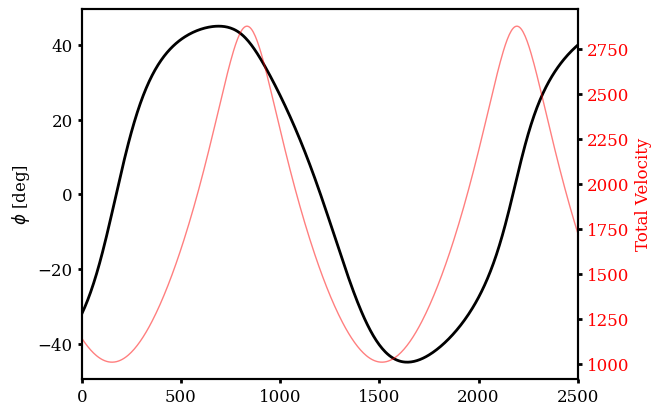

In [382]:

fig, ax1 = plt.subplots()


ax1.plot(time, np.rad2deg(np.arctan(p[0] / v_tot)), color="black", lw=2, zorder=5)

ax1.set_ylabel("$\phi$ [deg]")

ax2 = ax1.twinx()
ax2.plot(time, v_tot, color="red", alpha=0.5)
ax2.set_ylabel('Total Velocity', color="Red")  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor="red")
plt.xlim(0, 2500)